# Getting started with `sbi`

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started_flexible.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started_flexible.ipynb) in the `sbi` repository.

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

**The overall goal of simulation-based inference is to algorithmically identify model parameters which are consistent with data.**

In this tutorial we demonstrate how to get started with the `sbi` toolbox and how to perform parameter inference on a simple model. 

Each of the implemented inference methods takes three inputs: 
1. observational data (or summary statistics thereof) - _the observations_
1. a candidate (mechanistic) model - _the simulator_
1. prior knowledge or constraints on model parameters - _the prior_



If you are new to simulation-based inference, please first read the information in the tutorial [README](README.md) or the [website](https://sbi-dev.github.io/sbi/) to familiarise with the motivation and relevant terms.

In [17]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

## Parameter inference in a linear Gaussian example



For this illustrative example, we consider a model _simulator_, that takes in 3 parameters ($\theta$). For simplicity, the _simulator_ outputs simulations of the same dimensionality and just adds 1.0 and some Gaussian noise to the parameter set. 

> Note: This is where you would specify your model _simulator_ and with its parameters. 

For the 3-dimensional parameter space we consider a uniform _prior_ between [-2,2].

> Note: This is where you would incorporate prior knowlegde about the parameters you want to infer, e.g., ranges known from literature. 



In [40]:
from sbi.inference import SNPE
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
# import your simulator, define your prior over the parameters
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def simulator(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1


# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

# sample parameters theta and observations x
inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 145 epochs.

In [18]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

We have to ensure that your _simulator_ and _prior_ adhere to the requirements of `sbi` such as returning `torch.Tensor`s in a standardised shape. 

You can do so with the `process_simulator()` and `process_prior()` functions, which prepare them appropriately. Finally, you can call `check_sbi_input()` to make sure they are consistent which each other.

In [19]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Next, we instantiate the inference object. Here, to neural perform posterior estimation (NPE):

> Note: Single round sequential NPE which we call via SNPE corresponds to NPE. 

> Note: This is where you could specify an alternative inference object such as (S)NRE for ratio estimation or (S)NLE for likelihood estimation. Here, you can see [all implemented methods.](16_implemented_methods.ipynb)



In [4]:
inference = SNPE(prior=prior)

Next, we need simulations or more specifically pairs of paramters $\theta$ which we sample from the _prior_ and correpsonding simulations $x = \mathrm{simulator} (\theta)$. The `sbi` helper function called `simulate_for_sbi` allows to parallelize your code with `joblib`.

 > Note: You might already have your own parameter, simulation pairs which were generated elsewhere (e.g., on a compute cluster), then you would add them here.  


In [20]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

We then pass the simulated data to the inference object. Both `theta` and `x` should be a `torch.Tensor` of type `float32`.

In [6]:
inference = inference.append_simulations(theta, x)

Next, we train the _neural density estimator_ to learn the association between the simulated data (or data features) and the underlying parameters:

In [7]:
density_estimator = inference.train()

 Neural network successfully converged after 52 epochs.

Finally, we use this _density estimator_ to build the posterior distribution $p(\theta|x)$, i.e., the distributions over paramters $\theta$ given observation $x$. 

Effectively, `build_posterior` acts as a wrapper for the raw _density estimator_ that among other features (which go beyond the scope of this introductory tutorial) allows us to sample parameters $\theta$ from the posterior via `.sample()`, i.e., parameters that are likely given the observation $x$. 

We can also get log-probabilities under the posterior via `.log_prob()`, i.e., we can evaluate the likelihood of parameters $\theta$ given the observation $x$. 

In [16]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Visualisations of the inferred posterior for a new observation

Let's say we have made some observation $x_{obs}$ for which we now want to infer the posterior:

In [21]:
x_obs = torch.zeros(3)

 Given this observation, we can then sample from the posterior $p(\theta|x_{obs})$ and visualise the univariate and pairwise marginals for the three parameters via `analysis.pairplot()`.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

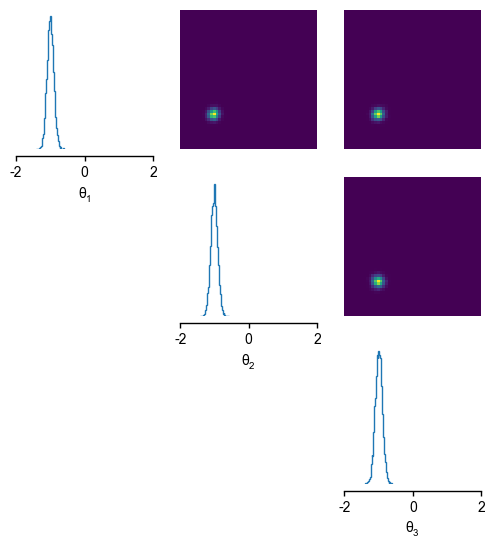

In [34]:
samples = posterior.sample((10000,), x=x_obs)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6),labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

## Assessing the posterior for a known $\theta, x$ - pair 

In [37]:
# generate a true theta and an observation x pair
theta_true = prior.sample((1,))
x_true = simulator(theta_true)
# randomly samle a different set of parameters theta
theta_diff = prior.sample((1,))

Now we can assess, if the interred distirbutions over the parameters match the parameters we used to generate our test sample.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

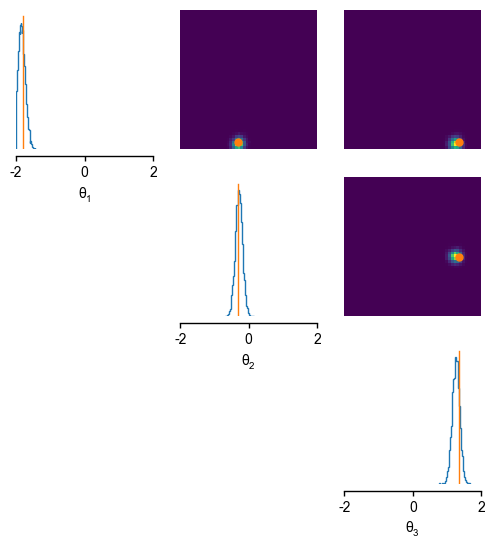

In [38]:
samples = posterior.sample((10000,), x=x_true)
_ = analysis.pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

The log-probability should ideally indicate that the true parameters are more likely given the correspinding observation than the different set of parameters. 

We can further assess the range of log probabilities of the samples from the posterior.

In [39]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_true)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_true)
log_probability_samples = posterior.log_prob(samples, x=x_true)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))


high for true theta : tensor([3.3860])
low for different theta : tensor([-82.1151])
range of posterior samples: min: tensor(-7.3333)  max : tensor(3.9999)


## Next steps

For `sbi` _contributers_ we recommend directly heading over to [Inferring parameters for multiple observations ](01_gaussian_amortized.ipynb) which introduces the concept of amortization. 


For _users_ and `sbi` beginners, we recommend going through [the example for a scientific simulator from neuroscience](../examples/00_HH_simulator.ipynb) to see a scientific use case.

Alternatively, also head over to [Inferring parameters for multiple observations ](01_gaussian_amortized.ipynb) which introduces the concept of amortization. 